In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import os
import csv
import sys

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from scipy.stats import linregress
from scipy.spatial.distance import cdist
from scipy.linalg import polar

sys.path.insert(0, "..")

from utils import geometry
from utils import fileio

In [2]:
tm_spot_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Stretched\\Tracked\\20231128_1_IP_GFPCAAX-CheHis_uf_8p6_SP\\5min_int\\green_edges/tm_spots_w0p5.csv', skiprows=[1,2,3])
tm_track_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Stretched\\Tracked\\20231128_1_IP_GFPCAAX-CheHis_uf_8p6_SP\\5min_int\\green_edges/tm_tracks_w0p5.csv', skiprows=[1,2,3])
tm_edge_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Stretched\\Tracked\\20231128_1_IP_GFPCAAX-CheHis_uf_8p6_SP\\5min_int\\green_edges/tm_edges_w0p5.csv', skiprows=[1,2,3])

In [4]:
dat_files=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Instant_data/20231128_1_IP_GFPCAAX-CheHis_uf_*/*/*/Data/*_cell_data_all*.csv'))
mat_dir=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Instant_data/20231128_1_IP_GFPCAAX-CheHis_uf_*/*/*/Matrices'))
save_folder='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/'
plot_dir = 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Instant_plots\\20231128_1_IP_GFPCAAX-CheHis_uf_8p6/'

In [5]:
micron_size=553.57
pixel_size=1024



In [6]:
Au=np.loadtxt(glob(mat_dir[0]+'/*Matrix_A*.txt')[0])
Bu=np.loadtxt(glob(mat_dir[0]+'/*Matrix_B*.txt')[0])
Cu=np.loadtxt(glob(mat_dir[0]+'/*Matrix_C*.txt')[0])
Ru=np.loadtxt(glob(mat_dir[0]+'/*Matrix_R*.txt')[0])

As=np.loadtxt(glob(mat_dir[1]+'/*Matrix_A*.txt')[0])
Bs=np.loadtxt(glob(mat_dir[1]+'/*Matrix_B*.txt')[0])
Cs=np.loadtxt(glob(mat_dir[1]+'/*Matrix_C*.txt')[0])
Rs=np.loadtxt(glob(mat_dir[1]+'/*Matrix_R*.txt')[0])

In [7]:
cec_u=geometry.get_edge_count(Bu)
cell_centres_u=geometry.get_cell_centres(Cu,Ru,cec_u)
cec_s=geometry.get_edge_count(Bs)
cell_centres_s=geometry.get_cell_centres(Cs,Rs,cec_s)

cc_u=cell_centres_u-np.mean(cell_centres_u, axis=0)
cc_s=cell_centres_s-np.mean(cell_centres_s, axis=0)

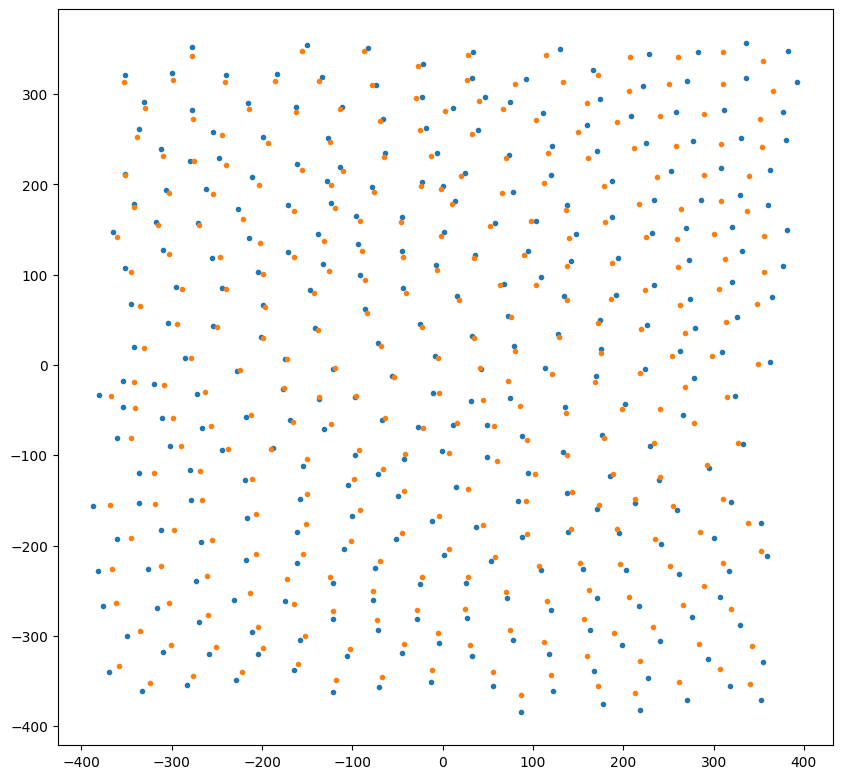

In [8]:
F=np.array([[1.3, 0], [0, (1/1.075)]])
Fcc_u=(F@cc_u.T).T
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'}, figsize=(10,10))
ax.scatter(Fcc_u[:,0], Fcc_u[:,1], marker='.')
ax.scatter(cc_s[:,0], cc_s[:,1], marker='.')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Stretched\\Tracked\\20231128_1_IP_GFPCAAX-CheHis_uf_8p6_SumP\\5min_int\\green_edges/check_trace_0p5_transformed.png'

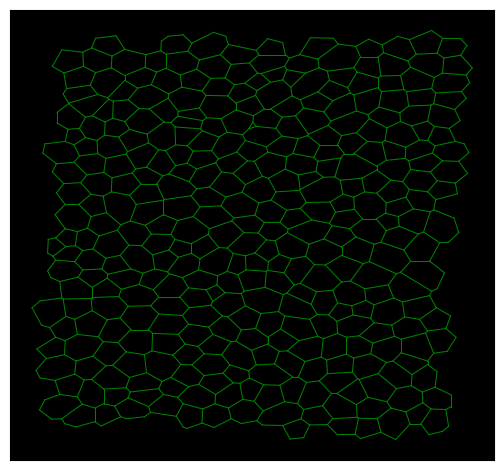

In [9]:
def make_polygon(i, C, R, cell_centres):
    """
    Generate polygon

    Parameters:
    i (int): cell id
    C (numpy array): Nc x Nv order array relating cells to vertices
    R (numpy array): vertex coordinates
    cell_centres (numpy array): cell centre coordinates
    """

    Ralpha=R[np.where(C[i,:]==1)[0]]-cell_centres[i] #ref frame of cell
    ang=np.arctan2(Ralpha[:,1], Ralpha[:,0])%(2*np.pi) #find angle with x axis
    R_ang=np.transpose(np.vstack((np.where(C[i,:]==1)[0], ang))) #stack index of vertices with angle
    ordered_vertices=R_ang[np.argsort(R_ang[:,-1], axis=0)] #sort by anticlockwise angle
    polygon = Polygon(R[ordered_vertices[:,0].astype(int)],closed = True)
    return polygon

def plot_edges(A, R, color):
    N_e=np.shape(A)[0]
    beg_edge = ((abs(A) - A)*0.5)@R
    end_edge = ((abs(A) + A)*0.5)@R
    for j in range(0,N_e):
        plt.plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],c=color,alpha=1.0,linestyle ='-', linewidth=0.75)

def plot_cell_centres(cell_centres, color):
    for i in range(len(cell_centres)):
        plt.plot(cell_centres[i,0],cell_centres[i,1],marker ='o',markersize=2, c=color)
        

def plot_polys(C, R, cell_centres):
    N_c=np.shape(C)[0]
    patches = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)

    p = PatchCollection(patches,alpha = 1.0)
    return p

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
Ru=Ru-np.mean(Ru, axis=0)

FRu=(F@Ru.T).T
## For colormap of continuous data

polys=plot_polys(Cu, FRu, Fcc_u)
polys.set_facecolor('black')

ax.add_collection(polys) 

ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

## Add edges to plot 
plot_edges(Au,FRu, 'green')

#plt.xlim(0, 600)
#plt.ylim(0,600)
ax.set_facecolor("#000000")
plt.gca().set_aspect('equal')
plt.tight_layout()

plt.savefig('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Stretched\\Tracked\\20231128_1_IP_GFPCAAX-CheHis_uf_8p6_SumP\\5min_int\\green_edges/check_trace_0p5_transformed.png', dpi=300)

In [10]:
cols=['cell_id', 'cell_perimeter_microns', 'cell_area_microns',
       'shape_parameter', 'circularity', 'cell_edge_count',
       'major_shape_axis_alignment_rads', 'cc_x', 'cc_y', 'track_id', 'spot_id', 'time', 'tm_frame']
dat_df=pd.DataFrame(columns=cols)

tm=tm_spot_dat[tm_spot_dat.FRAME==0][['ID','TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']]


A=np.loadtxt(glob(mat_dir[0]+'/*Matrix_A*.txt')[0])
B=np.loadtxt(glob(mat_dir[0]+'/*Matrix_B*.txt')[0])
C=np.loadtxt(glob(mat_dir[0]+'/*Matrix_C*.txt')[0])
R=np.loadtxt(glob(mat_dir[0]+'/*Matrix_R*.txt')[0])

dat=pd.read_csv(dat_files[0])

cell_edge_count=geometry.get_edge_count(B)
cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)

scale_factor=0.65

cc=np.vstack((cell_centres[:,0]-np.mean(cell_centres[:,0]),cell_centres[:,1]-np.mean(cell_centres[:,1]))).T
tm_cc=scale_factor*np.vstack((tm.POSITION_X-np.mean(tm.POSITION_X), -tm.POSITION_Y-np.mean(-tm.POSITION_Y))).T
F=np.array([[1.3, 0], [0, (1/1.075)]])
Fcc=(F@cc.T).T
# plt.scatter(Fcc[:,0], Fcc[:,1])
# plt.scatter(tm_cc[:,0], tm_cc[:,1])
# plt.title(str(0))
# plt.show()

dists=cdist(Fcc, tm_cc)
min_id=np.where(dists==np.min(dists, axis=0))[1]

dat['cc_x']=cc[:,0]
dat['cc_y']=cc[:,1]
dat['track_id']=np.array(tm.TRACK_ID.iloc[min_id])
dat['spot_id']=np.array(tm.ID.iloc[min_id])
dat['tm_frame']=np.array(tm.FRAME.iloc[min_id])
dat['time']=dat['tm_frame']*5



dat_df=pd.concat([dat_df,dat], ignore_index=True)


for i in range(1,len(dat_files)): #don't include 0p5 here
    tm=tm_spot_dat[tm_spot_dat.FRAME==i][['ID','TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']]

    

    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])

    dat=pd.read_csv(dat_files[i])

    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)

    scale_factor=0.625+0.0011*i

    cc=np.vstack((cell_centres[:,0]-np.mean(cell_centres[:,0]),cell_centres[:,1]-np.mean(cell_centres[:,1]))).T
    tm_cc=scale_factor*np.vstack((tm.POSITION_X-np.mean(tm.POSITION_X), -tm.POSITION_Y-np.mean(-tm.POSITION_Y))).T

    # plt.scatter(cc[:,0], cc[:,1])
    # plt.scatter(tm_cc[:,0], tm_cc[:,1])
    # plt.title(str(i))
    # plt.show()

    dists=cdist(cc, tm_cc)
    min_id=np.where(dists==np.min(dists, axis=0))[1]

    dat['cc_x']=cc[:,0]
    dat['cc_y']=cc[:,1]
    dat['track_id']=np.array(tm.TRACK_ID.iloc[min_id])
    dat['spot_id']=np.array(tm.ID.iloc[min_id])
    dat['tm_frame']=np.array(tm.FRAME.iloc[min_id])
    dat['time']=dat['tm_frame']*5
    


    dat_df=pd.concat([dat_df,dat], ignore_index=True)


# t_id=np.max(dat_df.track_id)
# Nc_orig=t_id
# for s in np.where(tm_track_dat.NUMBER_SPLITS>0)[0]:
#     split=np.where(np.unique(dat_df[dat_df.track_id==s].tm_frame,return_counts=True)[1]>1)[0][0]

#     edges=tm_edge_dat[tm_edge_dat.TRACK_ID==s]
#     n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
#     track_a=[]
#     track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
#     index_a=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_a[-1])].index[0]
#     dat_df.track_id.loc[index_a]=t_id+1
#     track_b=[]
#     track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])
#     index_b=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_b[-1])].index[0]
#     dat_df.track_id.loc[index_b]=t_id+2
#     for i in range(split+1,len(dat_files)):
#         n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
#         t_a=n_edges[n_edges.SPOT_SOURCE_ID==track_a[-1]].SPOT_TARGET_ID.iloc[0]
#         t_b=n_edges[n_edges.SPOT_SOURCE_ID==track_b[-1]].SPOT_TARGET_ID.iloc[0]
#         track_a.append(t_a)
#         track_b.append(t_b)
#         index_a=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_a[-1])].index[0]
#         index_b=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_b[-1])].index[0]
#         dat_df.track_id.loc[index_a]=t_id+1
#         dat_df.track_id.loc[index_b]=t_id+2
#     t_id=t_id+2

# dat_df=dat_df.rename(columns={"cell_id": "cell_id_old", "track_id": "cell_id_new"})
# dat_df['angle_horizontal']=abs(np.where(dat_df.major_shape_axis_alignment_rads<np.pi/2,dat_df.major_shape_axis_alignment_rads, dat_df.major_shape_axis_alignment_rads-np.pi))



dat_df["parent_id"] = np.nan
dat_df["divisions"] = 0

t_id=np.max(dat_df.track_id)
Nc_orig=t_id
max_splits=np.max(tm_track_dat.NUMBER_SPLITS)


for s in tm_track_dat[tm_track_dat.NUMBER_SPLITS>0].TRACK_ID:

    
    splits=np.array(tm_track_dat[tm_track_dat.TRACK_ID==s].NUMBER_SPLITS)[0]

    split=np.where(np.unique(dat_df[dat_df.track_id==s].tm_frame,return_counts=True)[1]>1)[0][0]


    edges=tm_edge_dat[tm_edge_dat.TRACK_ID==s]
    n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
    track_a=[]
    track_b=[]
    track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
    track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])
    
    for i in range(split+1,len(dat_files)):
        n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
        t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
        t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
        track_a=track_a+t_a
        track_b=track_b+t_b
    
    new_id_a=t_id+1
    new_id_b=t_id+2

    dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_a
    dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_b
    dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=s
    dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
    tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_a
    tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_b




    t_id=t_id+2

    if splits>1:
        if(len(np.where(np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[1]>1)[0])>0):
                split=np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[0][np.where(np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[1]>1)[0][0]]

                edges=tm_edge_dat[tm_edge_dat.TRACK_ID==new_id_a]
                n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                track_a=[]
                track_b=[]
                track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
                track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])

                for i in range(split+1,len(dat_files)):
                    n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                    t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
                    t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
                    track_a=track_a+t_a
                    track_b=track_b+t_b

                new_id_aa=t_id+1
                new_id_bb=t_id+2

                dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_aa
                dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_bb
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=new_id_a
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_aa
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_bb

                t_id=t_id+2

        if(len(np.where(np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[1]>1)[0]) >0):
                split=np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[0][np.where(np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[1]>1)[0][0]]

                edges=tm_edge_dat[tm_edge_dat.TRACK_ID==new_id_b]
                n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                track_a=[]
                track_b=[]
                track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
                track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])

                for i in range(split+1,len(dat_files)):
                    n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                    t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
                    t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
                    track_a=track_a+t_a
                    track_b=track_b+t_b

                new_id_aa=t_id+1
                new_id_bb=t_id+2

                dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_aa
                dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_bb
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=new_id_b
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_aa
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_bb

                t_id=t_id+2

dat_df=dat_df.rename(columns={"cell_id": "cell_id_old", "track_id": "cell_id_new"})
dat_df['angle_horizontal']=abs(np.where(dat_df.major_shape_axis_alignment_rads<np.pi/2,dat_df.major_shape_axis_alignment_rads, dat_df.major_shape_axis_alignment_rads-np.pi))
#dat_df.to_csv(save_folder+"/20231019_1_IP_GFPCAAX-CheHis_uu_0p5_SP_pooled.csv",index=False)
dat_df['cc_x']=dat_df['cc_x']*(micron_size/pixel_size)
dat_df['cc_y']=dat_df['cc_y']*(micron_size/pixel_size)



dat_df.to_csv(save_folder+"/20231128_1_IP_GFPCAAX-CheHis_uf_8p6_SP_pooled_mech.csv",index=False)

In [13]:
dat_df=dat_df.sort_values(['time', 'cell_id_new']).reset_index(drop=True)
dat_df['area_norm']=dat_df.cell_area_microns/(dat_df.groupby('cell_id_new').cell_area_microns.transform('first'))
dat_df['perimeter_norm']=dat_df.cell_perimeter_microns/(dat_df.groupby('cell_id_new').cell_perimeter_microns.transform('first'))
dat_df['circularity_norm']=dat_df.circularity/(dat_df.groupby('cell_id_new').circularity.transform('first'))

In [14]:
orig_cells=dat_df[dat_df.cell_id_new<=Nc_orig]

no_div=orig_cells[~orig_cells.cell_id_new.isin(np.where(tm_track_dat.NUMBER_SPLITS>0)[0])]
div_cells=orig_cells[orig_cells.cell_id_new.isin(np.where(tm_track_dat.NUMBER_SPLITS>0)[0])]
daughter_cells=dat_df[dat_df.cell_id_new>Nc_orig]

In [15]:
dat_df.groupby('time').count()

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,spot_id,tm_frame,parent_id,divisions,angle_horizontal,area_norm,perimeter_norm,circularity_norm
time,,,,,,,,,,,,,,,,,,
0,308,308,308,308,308,308,308,308,308,308,308,308,0,308,308,308,308,308
5,312,312,312,312,312,312,312,312,312,312,312,312,8,312,312,312,312,312
10,315,315,315,315,315,315,315,315,315,315,315,315,14,315,315,315,315,315
15,316,316,316,316,316,316,316,316,316,316,316,316,16,316,316,316,316,316
20,322,322,322,322,322,322,322,322,322,322,322,322,26,322,322,322,322,322
25,324,324,324,324,324,324,324,324,324,324,324,324,30,324,324,324,324,324
30,325,325,325,325,325,325,325,325,325,325,325,325,32,325,325,325,325,325
35,326,326,326,326,326,326,326,326,326,326,326,326,34,326,326,326,326,326
40,327,327,327,327,327,327,327,327,327,327,327,327,36,327,327,327,327,327


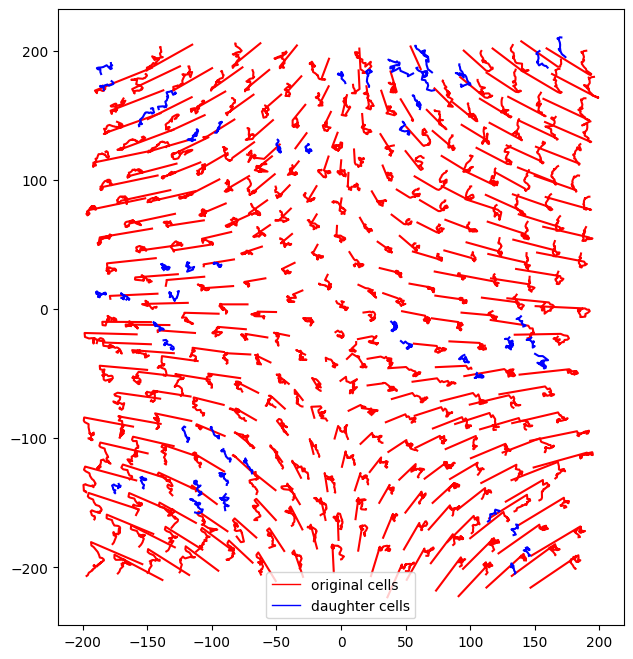

In [16]:
fig,ax=plt.subplots(figsize=(8, 8))
for i in (np.unique(dat_df.cell_id_new)):
    ax.plot(orig_cells[orig_cells.cell_id_new==i].cc_x, orig_cells[orig_cells.cell_id_new==i].cc_y, c='red', label='original cells')
    ax.plot(daughter_cells[daughter_cells.cell_id_new==i].cc_x, daughter_cells[daughter_cells.cell_id_new==i].cc_y, c='blue', label=daughter_cells)

ax.set_aspect('equal')
legend_elements = [Line2D([0], [0], color='r', lw=1, label='original cells'),
                  Line2D([0], [0], color='b', lw=1, label='daughter cells')]
ax.legend(handles=legend_elements)
plt.savefig(plot_dir+'/cell_tracks.png', dpi=300, bbox_inches='tight')

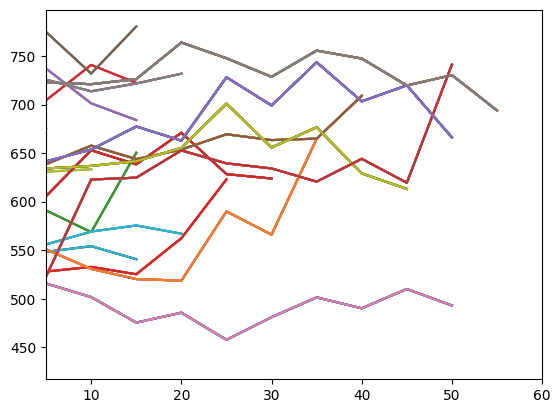

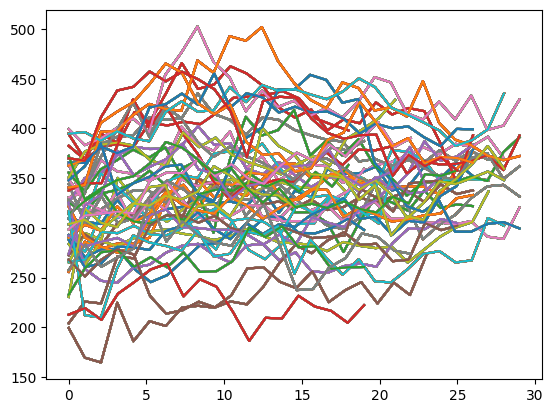

In [24]:
for i in (div_cells.cell_id_new):
    plt.plot(div_cells[div_cells.cell_id_new==i].time, div_cells[div_cells.cell_id_new==i].cell_area_microns)
    
plt.xlim(5,60)
plt.show()

for i in (daughter_cells.cell_id_new):
    plt.plot(np.linspace(0,len(daughter_cells[daughter_cells.cell_id_new==i].circularity), len(daughter_cells[daughter_cells.cell_id_new==i].circularity )), daughter_cells[daughter_cells.cell_id_new==i].cell_area_microns)
    
#plt.xlim(5,60)

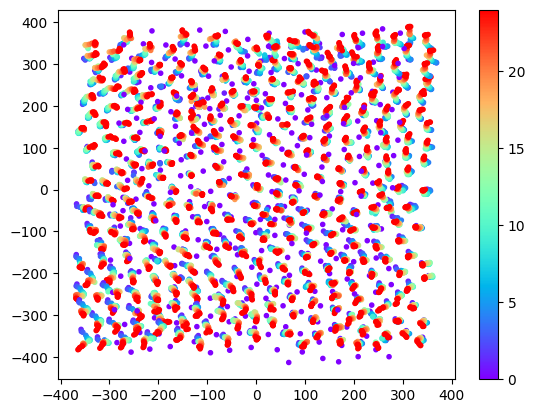

In [28]:
for i in range(np.max(dat_df.cell_id_new)):
    plt.scatter(dat_df[dat_df.cell_id_new==i].cc_x, dat_df[dat_df.cell_id_new==i].cc_y, marker='.', c=dat_df[dat_df.cell_id_new==i].tm_frame, cmap='rainbow', vmin=0, vmax=24)
plt.colorbar()

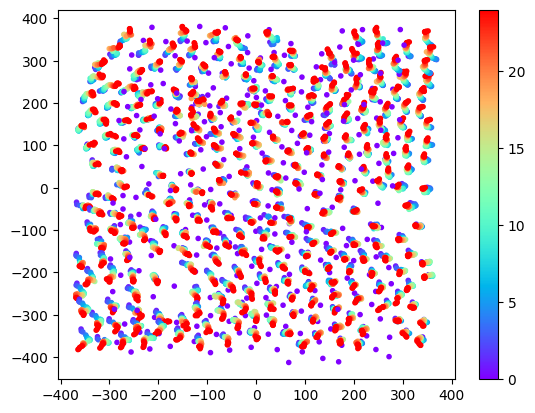

In [240]:
for i in range(np.max(no_div.cell_id_new)):
    plt.scatter(no_div[no_div.cell_id_new==i].cc_x, no_div[no_div.cell_id_new==i].cc_y, marker='.', c=no_div[no_div.cell_id_new==i].tm_frame, cmap='rainbow', vmin=0, vmax=24)
plt.colorbar()

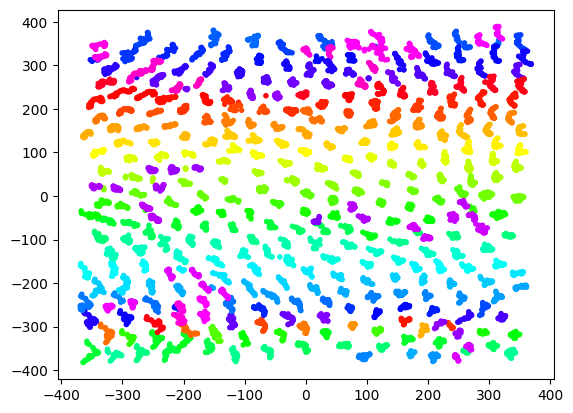

In [29]:
for i in range(1,30):
    plt.scatter(dat_df[dat_df.tm_frame==i].cc_x, dat_df[dat_df.tm_frame==i].cc_y, marker='.', c=dat_df[dat_df.tm_frame==i].cell_id_new,cmap='gist_rainbow', vmin=0, vmax=np.max(dat_df.cell_id_new))


In [30]:
tm_track_dat.NUMBER_SPLITS.iloc[np.where(tm_track_dat.NUMBER_SPLITS>0)[0]]

9      1
24     1
95     1
99     1
110    1
128    1
130    1
131    1
150    1
170    1
174    1
213    1
234    1
239    1
249    1
251    1
252    1
260    1
268    1
270    1
273    1
289    1
292    1
305    1
Name: NUMBER_SPLITS, dtype: int64

In [18]:
nd_t0=no_div[no_div.tm_frame==0][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
nd_t5=no_div[no_div.tm_frame==1][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
nd_t145=no_div[no_div.tm_frame==29][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
cc_us=pd.merge(nd_t0, nd_t5, on='cell_id_new', suffixes=("_u", "_s"))
cc_us['cc_dx']=cc_us.cc_x_s-cc_us.cc_x_u
cc_us['cc_dy']=cc_us.cc_y_s-cc_us.cc_y_u

cc_sr=pd.merge(nd_t5, nd_t145, on='cell_id_new', suffixes=("_s", "_r"))
cc_sr['cc_dx']=cc_sr.cc_x_r-cc_sr.cc_x_s
cc_sr['cc_dy']=cc_sr.cc_y_r-cc_sr.cc_y_s
cc_0=np.transpose(np.vstack((cc_us.cc_x_u, cc_us.cc_y_u)))
cc_5=np.transpose(np.vstack((cc_us.cc_x_s, cc_us.cc_y_s)))
aft=np.array(cv2.estimateAffine2D(cc_0, cc_5, method=cv2.RANSAC)[0][:,:2])
polar(aft)

(array([[ 0.99994922, -0.0100777 ],
        [ 0.0100777 ,  0.99994922]]),
 array([[ 1.26778591, -0.00956268],
        [-0.00956268,  0.90946294]]))

In [188]:
cc_us

,cell_id_new,cc_x_u,cc_y_u,tm_frame_u,cc_x_s,cc_y_s,tm_frame_s,cc_dx,cc_dy
0,38,0.304263,213.151272,0,-1.338072,194.548955,1,-1.642336,-18.602317
1,195,-54.862403,-130.182062,0,-66.338072,-115.534379,1,-11.475669,14.647683
2,83,84.137597,104.817938,0,103.461928,88.215621,1,19.324331,-16.602317
3,291,57.637597,312.817938,0,67.161928,283.965621,1,9.524331,-28.852317
4,240,66.437597,-412.782062,0,87.261928,-365.784379,1,20.824331,46.997683
...,...,...,...,...,...,...,...,...,...
279,91,103.012597,82.442938,0,137.661928,72.215621,1,34.649331,-10.227317
280,75,210.137597,125.192938,0,261.036928,108.590621,1,50.899331,-16.602317
281,72,149.512597,127.942938,0,188.036928,113.340621,1,38.524331,-14.602317
282,34,-131.737403,190.567938,0,-164.713072,171.090621,1,-32.975669,-19.477317


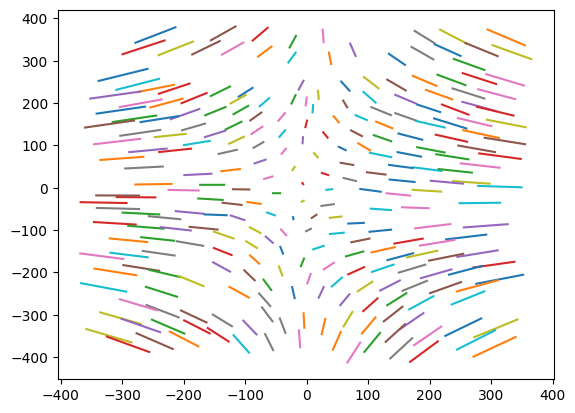

In [200]:
for i in range(len(cc_us)):
    plt.plot([nd_t0[nd_t0.cell_id_new==i].cc_x, nd_t5[nd_t5.cell_id_new==i].cc_x],[nd_t0[nd_t0.cell_id_new==i].cc_y, nd_t5[nd_t5.cell_id_new==i].cc_y])

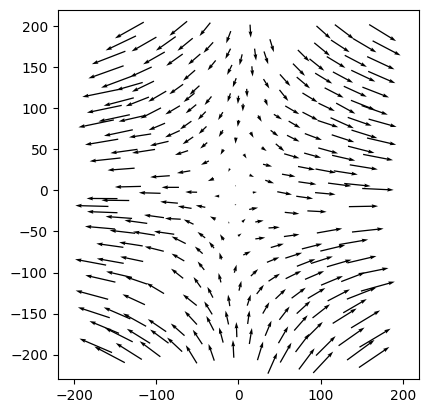

In [23]:
dx= cc_us.cc_dx
dy=cc_us.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

plt.quiver(cc_us.cc_x_u,cc_us.cc_y_u, dx, dy,units='xy', angles='xy', scale=1, zorder=10)

dx= cc_sr.cc_dx
dy=cc_sr.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

#plt.quiver(cc_sr.cc_x_s,cc_sr.cc_y_s, dx, dy,units='xy', angles='xy', scale=1, zorder=10, color='red')
plt.xlim(-220,220)
plt.ylim(-230,220)


plt.gca().set_aspect('equal')

plt.savefig(plot_dir+'/cell_centre_stretch.png', dpi=300, bbox_inches='tight')

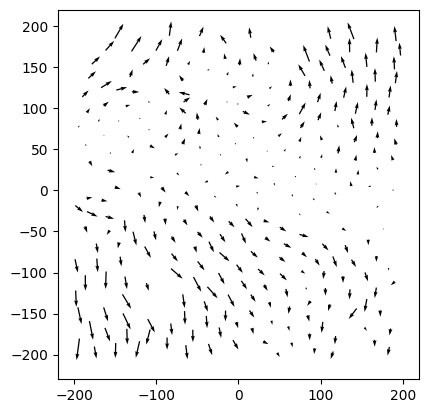

In [24]:
dx= cc_sr.cc_dx
dy=cc_sr.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

plt.quiver(cc_sr.cc_x_s,cc_sr.cc_y_s, dx, dy,units='xy', angles='xy', scale=1, zorder=10)
plt.xlim(-220,220)
plt.ylim(-230,220)


plt.gca().set_aspect('equal')
plt.savefig(plot_dir+'/cell_centre_relaxation.png', dpi=300, bbox_inches='tight')

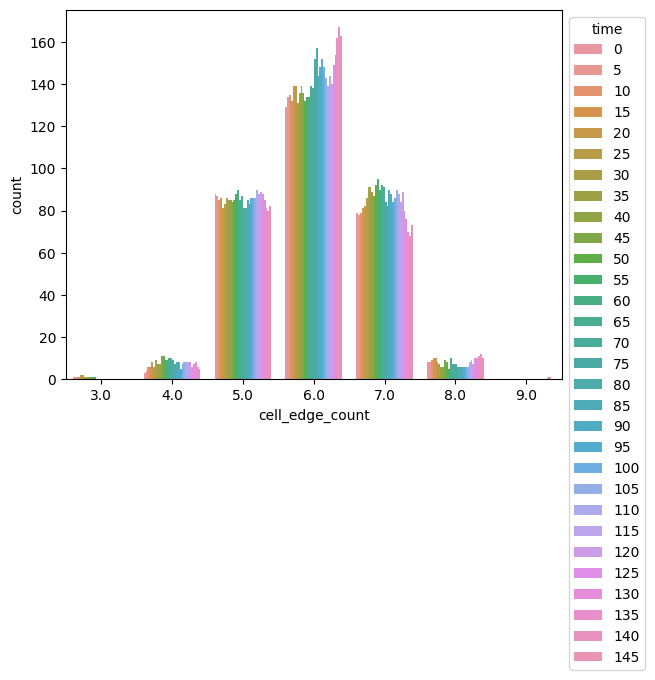

In [34]:
sns.countplot(data=dat_df,x='cell_edge_count', hue='time')
plt.legend( loc="upper left", bbox_to_anchor=(1, 1), title='time')
plt.savefig(plot_dir+'/cell_edges_hist.png', dpi=300, bbox_inches='tight')

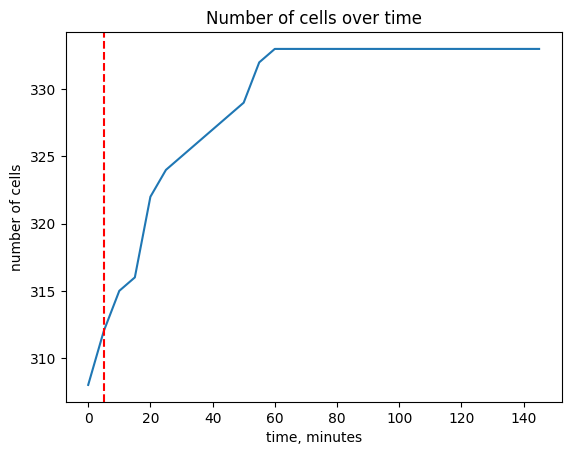

In [35]:
plt.plot(dat_df.groupby('time').count().cell_id_new)
plt.axvline(5, c='r', linestyle='--')
plt.xlabel('time, minutes')
plt.ylabel('number of cells')
plt.title("Number of cells over time")

plt.savefig(plot_dir+'/Number_cells_time.png', dpi=300, bbox_inches='tight')

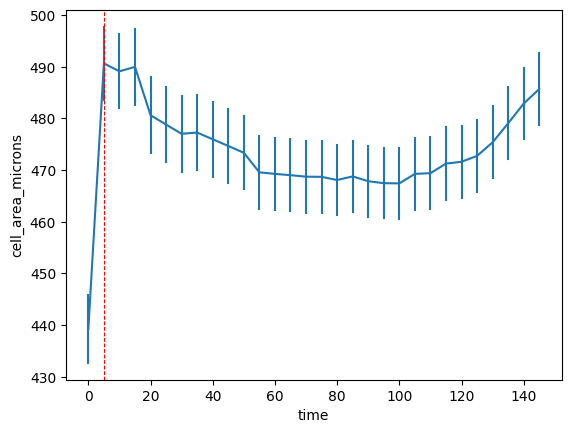

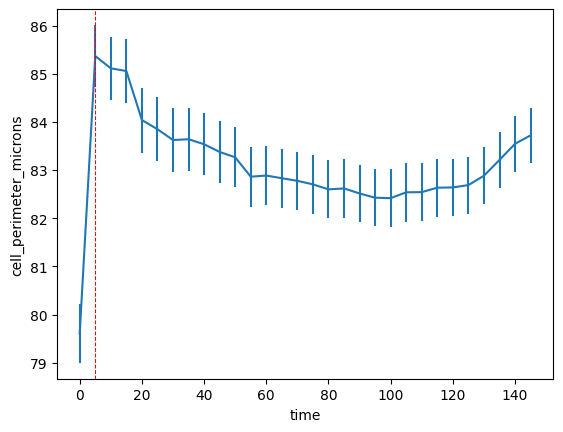

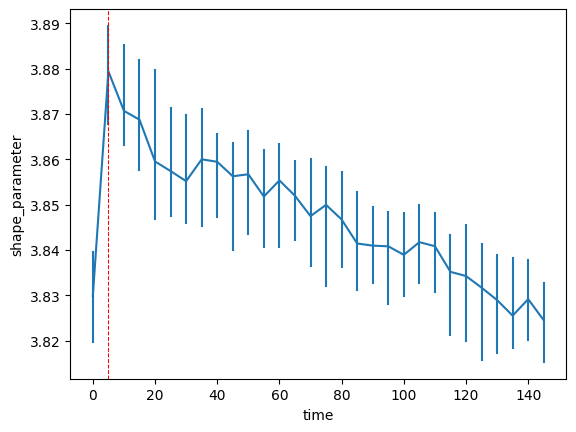

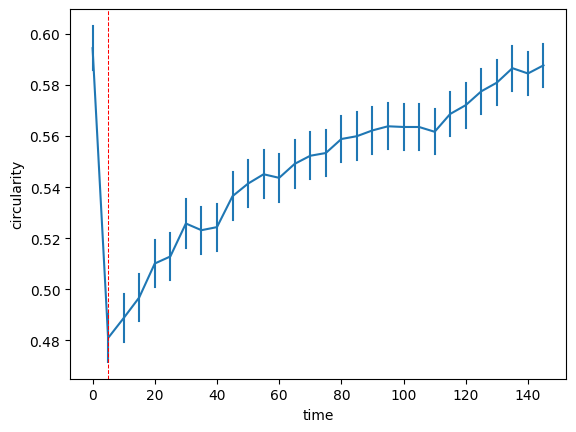

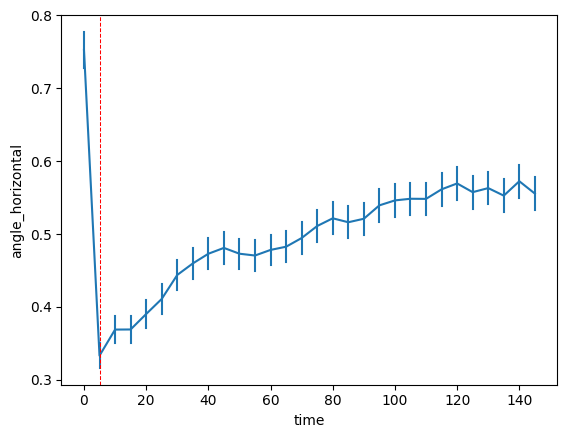

In [36]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

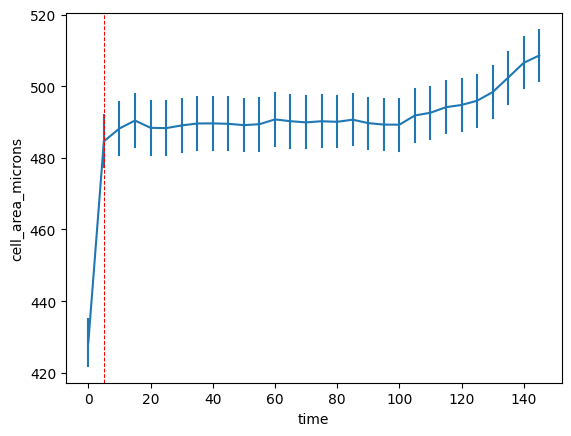

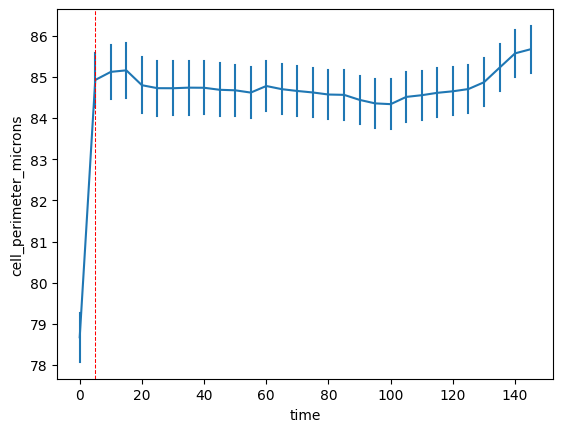

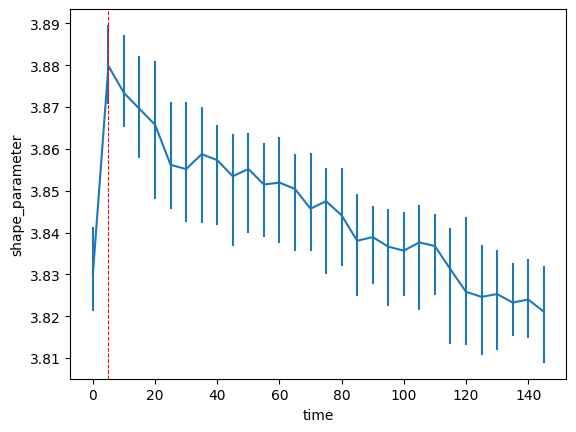

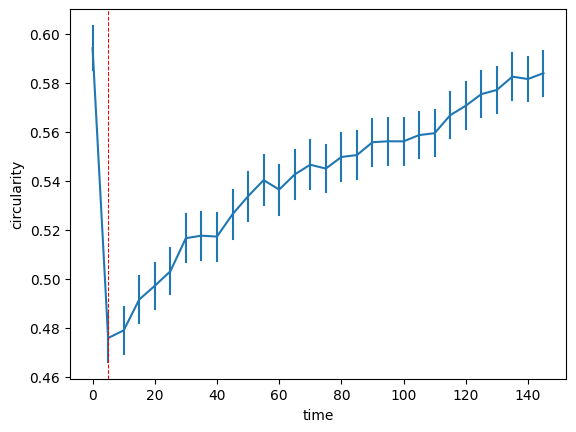

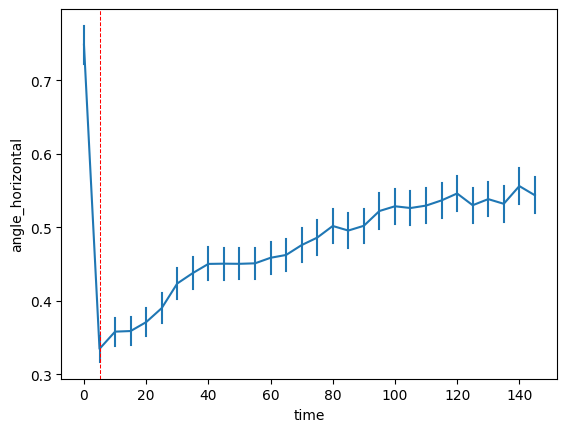

In [37]:
sns.lineplot(data=no_div, y='cell_area_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/no_div_mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=no_div, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/no_div_mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=no_div, y='shape_parameter', x='time',err_style='bars', estimator='median')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/no_div_median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=no_div, y='circularity', x='time',err_style='bars', errorbar='se')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/no_div_mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=no_div, y='angle_horizontal', x='time',err_style='bars', errorbar='se')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/no_div_mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

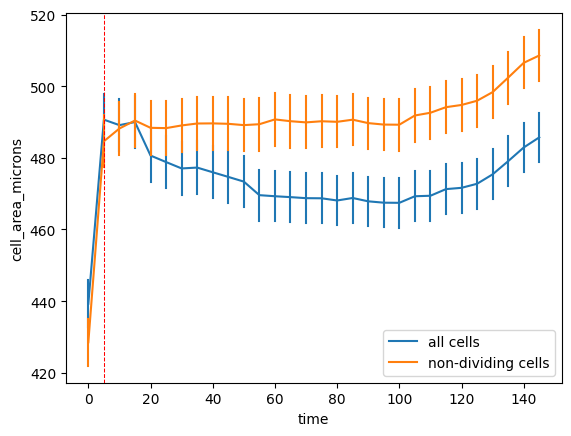

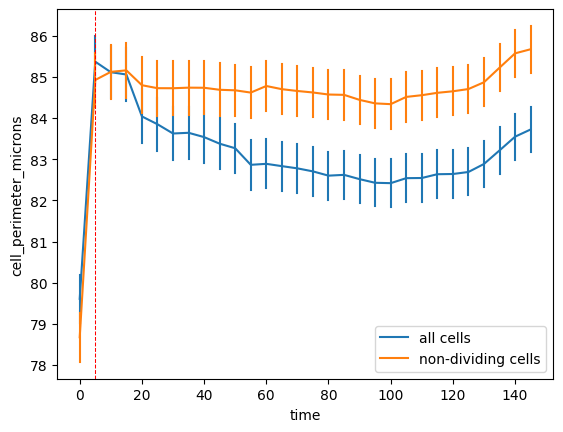

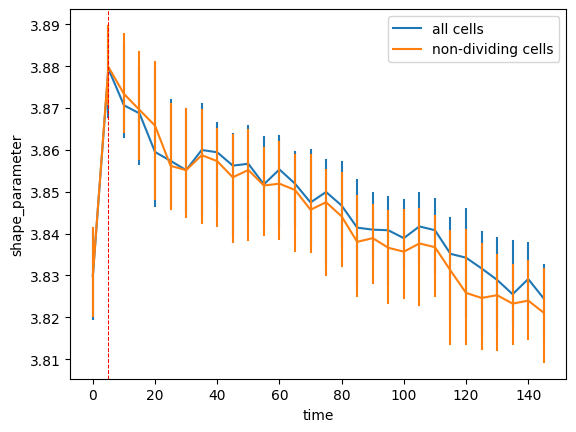

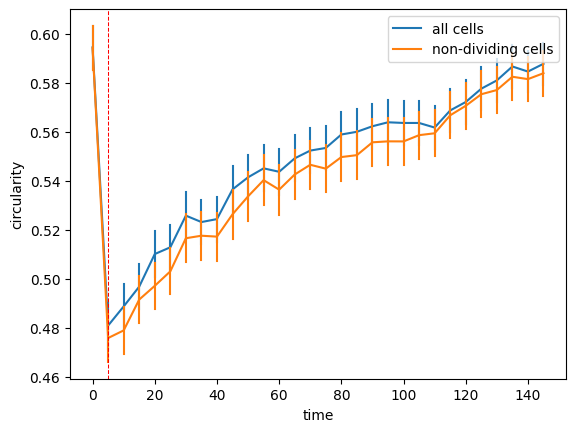

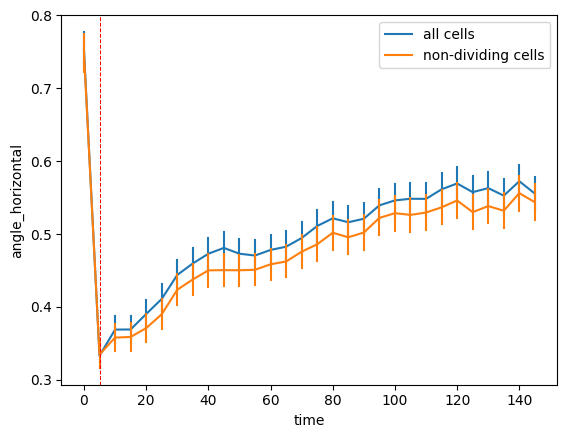

In [38]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median', label='all cells')
sns.lineplot(data=no_div, y='shape_parameter', x='time',err_style='bars', estimator='median', label='non-dividing cells')
plt.legend()
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='circularity', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

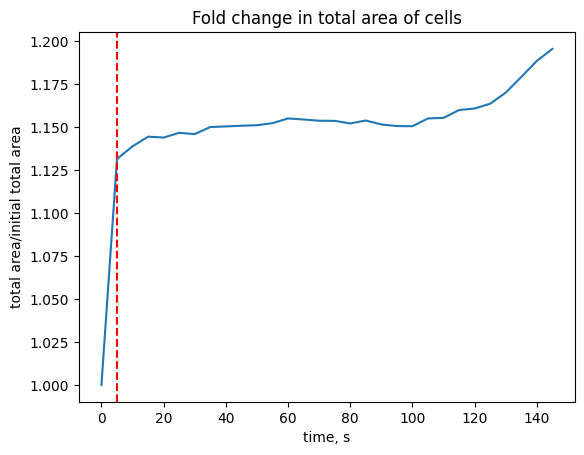

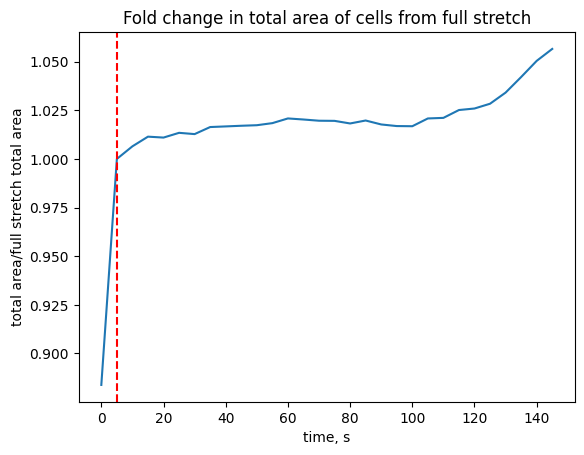

In [39]:
t=np.linspace(0, 145, 30)
plt.plot(t,dat_df.groupby('time').cell_area_microns.sum()/(dat_df[dat_df.time==0].sum().cell_area_microns))
plt.axvline(5, linestyle='--', color='red')
plt.xlabel("time, s")
plt.ylabel("total area/initial total area")
plt.title("Fold change in total area of cells")
plt.savefig(plot_dir+'/total_area.png', dpi=300, bbox_inches='tight')

plt.show()

t=np.linspace(0, 145, 30)
plt.plot(t,dat_df.groupby('time').cell_area_microns.sum()/(dat_df[dat_df.time==5].sum().cell_area_microns))
plt.axvline(5, linestyle='--', color='red')
plt.xlabel("time, s")
plt.ylabel("total area/full stretch total area")
plt.title("Fold change in total area of cells from full stretch")
plt.savefig(plot_dir+'/total_area_full_stretch.png', dpi=300, bbox_inches='tight')

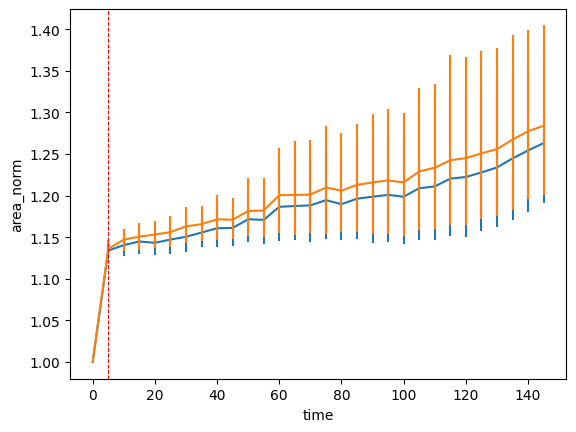

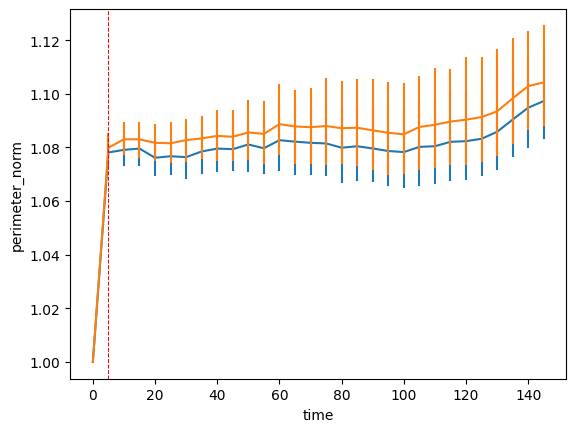

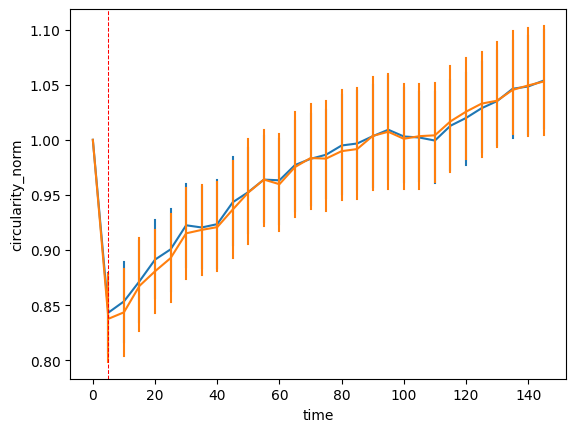

In [40]:
sns.lineplot(data=dat_df, y='area_norm', x='time',err_style='bars')
sns.lineplot(data=no_div, y='area_norm', x='time',err_style='bars')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
#plt.savefig(plot_dir+'/mean_area_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='perimeter_norm', x='time',err_style='bars')
sns.lineplot(data=no_div, y='perimeter_norm', x='time',err_style='bars')

plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
#plt.savefig(plot_dir+'/mean_perimeter_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity_norm', x='time',err_style='bars')
sns.lineplot(data=no_div, y='circularity_norm', x='time',err_style='bars')

plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
#plt.savefig(plot_dir+'/mean_circ_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()

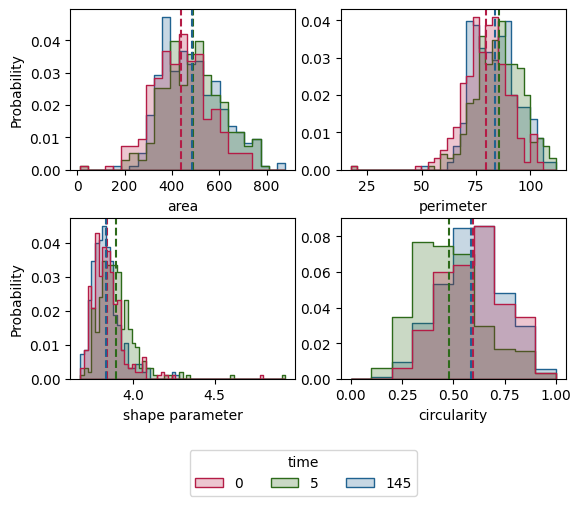

In [43]:
fig, ax=plt.subplots(2,2)
g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==5)| (dat_df.time==145)], hue='time',x='cell_area_microns',stat='probability', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[0,0], legend=False)
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==0].cell_area_microns), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==5].cell_area_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==145].cell_area_microns), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==5)| (dat_df.time==145)], hue='time',x='cell_perimeter_microns',stat='probability', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[0,1], legend=False)
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==0].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==5].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==145].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==5)| (dat_df.time==145)], hue='time',x='circularity', element="step", stat='probability',palette=sns.husl_palette(3,l=.4), ax=ax[1,1], legend=False , binrange=[0,1], bins=10)
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==0].circularity), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==5].circularity), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==145].circularity), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==5)| (dat_df.time==145)], hue='time',x='shape_parameter', element="step",stat='probability', palette=sns.husl_palette(3,l=.4), ax=ax[1,0], legend=True)
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==0].shape_parameter), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==5].shape_parameter), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==145].shape_parameter), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

plt.subplots_adjust(hspace=0.3)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,1].set_xlabel('perimeter')
ax[1,1].set_xlabel('circularity')
ax[1,0].set_xlabel('shape parameter')
ax[0,0].set_xlabel('area')
sns.move_legend(g, "upper left", bbox_to_anchor=(0.5, -0.4), frameon=True, ncol=3)
plt.savefig(plot_dir+'/cell_quantities_hists.png', dpi=300, bbox_inches='tight')

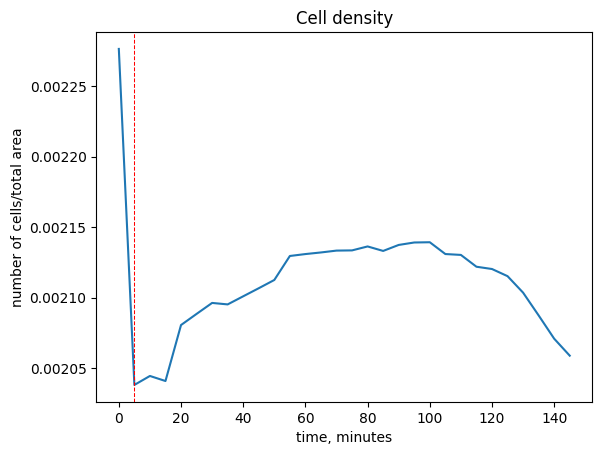

In [42]:
#cell density
plt.plot(dat_df.groupby('time').count().cell_id_new/(dat_df.groupby('time').cell_area_microns.sum()))
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)

plt.xlabel('time, minutes')
plt.ylabel('number of cells/total area')
plt.title("Cell density")

plt.savefig(plot_dir+'/cell_density_time.png', dpi=300, bbox_inches='tight')

In [46]:
dat_df[dat_df.time==5][['cell_id_new', 'circularity_norm', 'area_norm']].sort_values('circularity_norm')

,cell_id_new,circularity_norm,area_norm
548,245,0.376368,1.251181
424,265,0.396060,1.110727
369,80,0.405731,1.120963
579,105,0.424484,1.257605
576,120,0.433167,1.148413
...,...,...,...
464,129,1.820739,1.134836
320,43,1.848018,1.039927
459,137,1.907900,1.046146
413,50,1.915241,1.020394


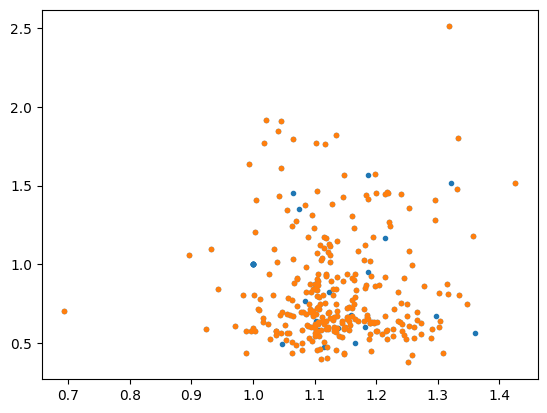

In [51]:
plt.scatter(dat_df[dat_df.time==5].area_norm, dat_df[dat_df.time==5].circularity_norm, marker='.')
plt.scatter(no_div[no_div.time==5].area_norm, no_div[no_div.time==5].circularity_norm, marker='.')